In [1]:
using Pkg
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `C:\Users\User\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\User\.julia\environments\v1.10\Manifest.toml`


In [16]:
using Random

mutable struct Particle
    particle_index::Int
    site_index::Int
    spin::Int
end

mutable struct Lattice
    particles::Vector{Particle}                                    # An array of all particles
    sites::Vector{Vector{Particle}}                                # 1D array of sites containing particles
    pops::Vector{Int}                                              # An array of population count in each site
    mags::Vector{Int}                                              # An array of total magnitization in each site
    size::Int                                                      # Number of sites
    num_particles::Int                                             # Number of particles
    equillibrium::Bool                                             # A flag indicating if the lattice reached equillibrium
    temperature::Float64                                           # Temperature parameter
    diffusion::Float64                                             # Diffusion rate of the lattice
    bias::Float64                                                  # Bias towards one side of the lattice
    seed::Int                                                      # Seed for random generation
    base_probability::Float64                                      # Exponent of negative beta
    site_probabilities::Vector{Float64}                            # Exponent of negative beta times magnitization of site divided by population
    step_count::Int                                                # Step count
    avg_pop::Vector{Float64}                                       # Average population over time for each site
    second_moment_pop::Matrix{Float64}                             # Second moments of population over time for each site
    avg_mag::Vector{Float64}                                       # Average magnetization over time for each site 
    second_moment_mag::Matrix{Float64}                             # Second moments of magnetization over time for each site
end

function Lattice(size::Int, num_particles::Int, temperature::Float64, diffusion::Float64, bias::Float64=0.0, seed::Int=0)
    @assert size > 0 "Size must be a positive whole number"
    @assert num_particles > 0 "Number of particles must be a positive whole number"
    @assert temperature ≥ 0.0 "Temperature must be non-negative"
    @assert 0.0 ≤ diffusion ≤ 1.0 "Diffusion rate must be between 0.0 and 1.0"
    @assert -1.0 ≤ bias ≤ 1.0 "Bias must be between -1.0 and 1.0"

    if seed != 0
        Random.seed!(seed)
    end
    
    particles::Vector{Particle} = []
    sites::Vector{Vector{Particle}} = [Particle[] for _ in 1:size]
    pops::Vector{Int} = zeros(Int, size)
    mags::Vector{Int} = zeros(Int, size)
    for i in 1:num_particles
        site = mod(i - 1, size) + 1
        particle = Particle(i, site, rand([1, -1]))
        push!(particles, particle)
        push!(sites[site], particle)
        pops[site] = pops[site] + 1
        mags[site] = mags[site] + particle.spin
    end
    
    avg_pop = zeros(Float64, size)
    second_moment_pop = zeros(Float64, size, size)
    avg_mag = zeros(Float64, size)
    second_moment_mag = zeros(Float64, size, size)
    
    equillibrium = false
    step_count = 1
    base_probability = exp(-1/temperature)
    site_probabilities = [base_probability ^ (mags[i] / pops[i]) for i in 1:size]
    
    return Lattice(particles, sites, pops, mags, size, num_particles, equillibrium, temperature, diffusion, bias, seed,base_probability, site_probabilities, step_count, avg_pop, second_moment_pop, avg_mag, second_moment_mag)
end

function step(lattice::Lattice)
    index = rand(1:lattice.num_particles)
    particle = lattice.particles[index]
    spin = particle.spin
    site_index = particle.site_index
    flip_spin_threshold = lattice.site_probabilities[site_index]
    if spin == -1
        flip_spin_threshold = 1 / flip_spin_threshold
    end
    normal = flip_spin_threshold + 1
    flip_spin_threshold = flip_spin_threshold / normal
    right_threshold = flip_spin_threshold + lattice.diffusion * (1 - spin * lattice.bias) / (2 * normal)
    left_threshold = right_threshold + lattice.diffusion * (1 + spin * lattice.bias) / (2 * normal)
    
    rand_num = rand()
    if rand_num <= flip_spin_threshold
        flip_spin(lattice, index)
    elseif rand_num <= right_threshold
        move_right(lattice, index)
    elseif rand_num <= left_threshold
        move_left(lattice, index)
    end
    update_stats(lattice)
end

function flip_spin(lattice::Lattice, index::Int)
    particle = lattice.particles[index]
    site = particle.site_index
    particle.spin = particle.spin * -1
    lattice.mags[site] = lattice.mags[site] + 2 * particle.spin
    lattice.site_probabilities[site] = lattice.base_probability ^ (lattice.mags[site] / lattice.pops[site])
end

function move_right(lattice::Lattice, index::Int)
    particle = lattice.particles[index]
    site = particle.site_index
    new_site = mod(site, lattice.size) + 1
    particle.site_index = new_site
    
    filter!(particle -> particle.particle_index != index, lattice.sites[site])
    push!(lattice.sites[new_site], particle)
    
    lattice.pops[site] = lattice.pops[site] - 1
    lattice.pops[new_site] = lattice.pops[new_site] + 1
    lattice.mags[site] = lattice.mags[site] - particle.spin
    lattice.mags[new_site] = lattice.mags[new_site] + particle.spin
    
    lattice.site_probabilities[site] = lattice.base_probability ^ (lattice.mags[site] / lattice.pops[site])
    lattice.site_probabilities[new_site] = lattice.base_probability ^ (lattice.mags[new_site] / lattice.pops[new_site])
end

function move_left(lattice::Lattice, index::Int)
    particle = lattice.particles[index]
    site = particle.site_index
    new_site = mod(index - 2, lattice.size) + 1
    particle.site_index = new_site
    
    filter!(particle -> particle.particle_index != index, lattice.sites[site])
    push!(lattice.sites[new_site], particle)
    
    lattice.pops[site] = lattice.pops[site] - 1
    lattice.pops[new_site] = lattice.pops[new_site] + 1
    lattice.mags[site] = lattice.mags[site] - particle.spin
    lattice.mags[new_site] = lattice.mags[new_site] + particle.spin
    
    lattice.site_probabilities[site] = lattice.base_probability ^ (lattice.mags[site] / lattice.pops[site])
    lattice.site_probabilities[new_site] = lattice.base_probability ^ (lattice.mags[new_site] / lattice.pops[new_site])
end

function flip_equillibrium_flag(lattice::Lattice)
    lattice.equillibrium = !lattice.equillibrium
    lattice.avg_pop = float.(lattice.pops)
    lattice.second_moment_pop = float.(lattice.pops) * float.(lattice.pops)'
    lattice.avg_mag = float.(lattice.mags)
    lattice.second_moment_mag = float.(lattice.mags) * float.(lattice.mags)'
    lattice.step_count = 1
end

function update_stats(lattice::Lattice)
    if lattice.equillibrium
        lattice.avg_pop .= lattice.avg_pop .+ float.(lattice.pops)
        lattice.second_moment_pop .= lattice.second_moment_pop .+ (float.(lattice.pops) * float.(lattice.pops)')
        lattice.avg_mag .= lattice.avg_mag .+ float.(lattice.mags)
        lattice.second_moment_mag .= lattice.second_moment_mag .+ (float.(lattice.mags) * float.(lattice.mags)')
        lattice.step_count = lattice.step_count + 1
    end
end

function sweep(lattice::Lattice)
    for _ in 1:lattice.size
        step(lattice)
    end
end

sweep (generic function with 1 method)

1465.735617 seconds (58.90 M allocations: 3.959 TiB, 12.40% gc time)


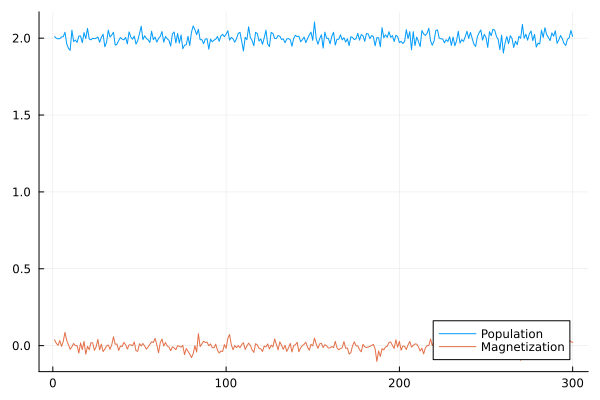

In [18]:
using Plots

lattice_size = 300
population = 600
lattice = Lattice(lattice_size, population, 0.8, 1.0, 0.9)
@time begin
    for _ in 1:100000
        sweep(lattice)
    end
    flip_equillibrium_flag(lattice)
    for _ in 1:10000
        sweep(lattice)
    end
end
p = plot(1:lattice_size, lattice.avg_pop / lattice.step_count, label="Population")
plot!(p, 1:lattice_size, lattice.avg_mag / lattice.step_count, label="Magnetization")
display(p)

1397.812633 seconds (49.72 M allocations: 3.960 TiB, 12.14% gc time)


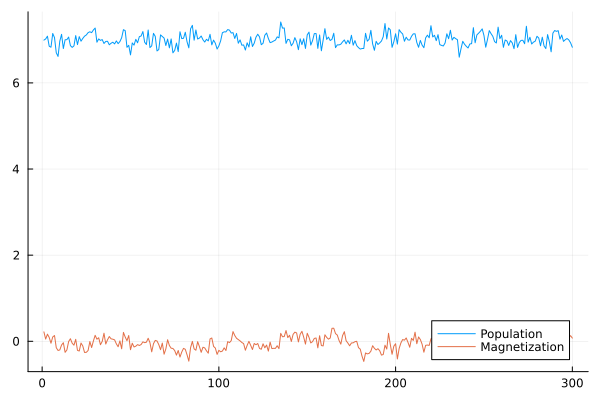

In [19]:
lattice_size = 300
population = 2100
lattice = Lattice(lattice_size, population, 0.5, 1.0, 0.9)
@time begin
    for _ in 1:100000
        sweep(lattice)
    end
    flip_equillibrium_flag(lattice)
    for _ in 1:10000
        sweep(lattice)
    end
end
p = plot(1:lattice_size, lattice.avg_pop / lattice.step_count, label="Population")
plot!(p, 1:lattice_size, lattice.avg_mag / lattice.step_count, label="Magnetization")
display(p)